In [27]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from random import randint

#for data visualization
import matplotlib.pyplot as plt
import plotly.graph_objects  as go

#DBSCAN clustering
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle

#train test split
from sklearn.model_selection import train_test_split

#Data Scaling
from sklearn.preprocessing import minmax_scale

#Data Modelling
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

#Evaluation metric
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [28]:
df = pd.read_csv('london_20k.csv')

In [29]:
df.head()

,photo_id,owner,gender,occupation,title,description,tags,faves,lat,lon,u_city,u_country,taken
0,12056545693,78191777@N00,1.0,Producer/DJ,près,<i>Let us draw near with a true heart in full ...,"clapham, london, england, ukgarage, dubstep, e...",0,51.465163,-0.129085,30307,USA,2014-01-20 15:19:44
1,12453639663,41087279@N00,1.0,Accountant,DSC_4241 Chyna Whyne from Jamaica Live at Char...,Chyna Whyne from Jamaica Live at Charlie Wrigh...,"chyna, whyne, from, jamaica, live, charlie, wr...",1,51.527672,-0.083648,London,England,2014-02-09 23:05:35
2,13185773995,41087279@N00,1.0,Accountant,DSC_6178 Flirt 69 Birthday Party at Charlie Wr...,Flirt 69 Birthday Party at Charlie Wrights Mus...,"flirt, 69, birthday, party, charlie, wrights, ...",0,51.527672,-0.083648,London,England,2014-03-14 22:24:02
3,13295046445,30625665@N00,1.0,NaN,Bank Limited,BREAKING NEWS My 806th picture to be viewed ov...,"bank, ex, cash, point, atm, brick, stone, lond...",5,51.513042,-0.089221,NaN,NaN,2014-03-20 09:13:03
4,13357656115,41087279@N00,1.0,Accountant,DSC_6743 Ray Estaire Live at Charlie Wrights M...,Ray Estaire Live at Charlie Wrights Music Loun...,"ray, estaire, jazz, ensemble, the, dominant, 7...",1,51.527672,-0.083648,London,England,2014-03-21 23:18:39


In [30]:
df.shape

(20000, 13)

In [31]:
#Drop unnecessary columns
df.drop(df.columns[[2,3,4,5,6,7,10,11]], axis=1, inplace=True)

In [32]:
df.head()

,photo_id,owner,lat,lon,taken
0,12056545693,78191777@N00,51.465163,-0.129085,2014-01-20 15:19:44
1,12453639663,41087279@N00,51.527672,-0.083648,2014-02-09 23:05:35
2,13185773995,41087279@N00,51.527672,-0.083648,2014-03-14 22:24:02
3,13295046445,30625665@N00,51.513042,-0.089221,2014-03-20 09:13:03
4,13357656115,41087279@N00,51.527672,-0.083648,2014-03-21 23:18:39


In [33]:
df.shape

(20000, 5)

In [34]:
df.dtypes

photo_id      int64
owner        object
lat         float64
lon         float64
taken        object
dtype: object

In [35]:
#change data type
data_type = {
    'photo_id': 'object',
    'owner': 'object',
    'lat': 'float32',
    'lon': 'float32',
    'taken': 'datetime64[ns]'
}
df = df.astype(data_type)

In [36]:
df.dtypes

photo_id            object
owner               object
lat                float32
lon                float32
taken       datetime64[ns]
dtype: object

In [37]:
#Check missing values in the data 
df.isnull().sum()

photo_id    0
owner       0
lat         0
lon         0
taken       0
dtype: int64

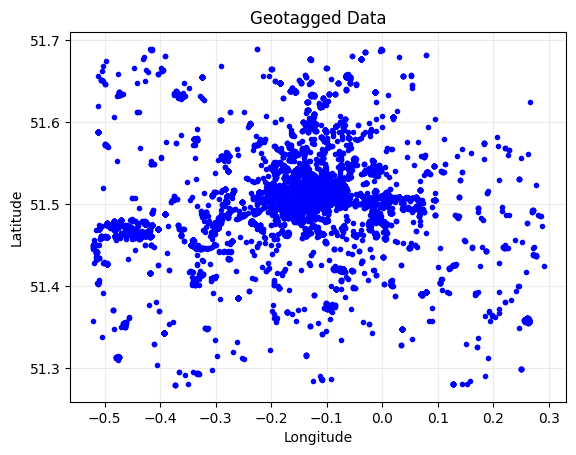

In [38]:
plt.plot(df['lon'],df['lat'], marker='.', linewidth = 0, color = 'blue')

plt.grid(which='major',color='lightgrey', alpha=0.45)
plt.title('Geotagged Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

#### Apply DBSCAN Clustering Technique 

In [39]:
#get the geotagged data 
dbscan_data = df[['lat','lon']]
dbscan_data.head()

,lat,lon
0,51.465164,-0.129085
1,51.527672,-0.083648
2,51.527672,-0.083648
3,51.513042,-0.089221
4,51.527672,-0.083648


In [40]:
kms_per_radian = 6371.0088
results = []

for m in (5, 10, 15, 20, 25, 30, 35):
    for e in (0.10, 0.15, 0.20, 0.30, 0.50, 0.80, 1):
        epsilon = e / kms_per_radian # radians = distance in km / 6371 (earth radius)
        db = DBSCAN(eps=epsilon, min_samples=m, algorithm='ball_tree', metric='haversine').fit(np.radians(dbscan_data))
        cluster_labels = db.labels_
        num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        results.append({'eps': e, 'min_samples': m, 'number_of_clusters': num_clusters})


In [41]:
x = pd.DataFrame(results)
x.head()

,eps,min_samples,number_of_clusters
0,0.10,5,396
1,0.15,5,333
2,0.20,5,316
3,0.30,5,251
4,0.50,5,167


In [42]:
Cluster_Eps = go.Figure()
Cluster_Samples = go.Figure()

for i in x.min_samples.unique():
    v = x[x.min_samples == i]
    Cluster_Eps.add_trace(go.Scatter(
        x=v.eps,
        y=v.number_of_clusters,
        name=f'Min Samples: {i} points',
        mode='lines+markers',
        marker=dict(size=8),
        line=dict(width=2),
        line_shape='spline'
    ))

for e in x.eps.unique():
    f = x[x.eps == e]
    Cluster_Samples.add_trace(go.Scatter(
        x=f.min_samples,
        y=f.number_of_clusters,
        name=f'Epsilon: {e} m',
        mode='lines+markers',
        marker=dict(size=8),
        line=dict(width=2),
        line_shape='spline'
    ))

Cluster_Eps.update_layout(
    title='No of cluster vs no. of Eps (according to diff min samples)',
    xaxis=dict(title='Epsilon', zeroline=False, dtick=0.05),
    yaxis=dict(title='Number of Cluster', zeroline=False)
)


Cluster_Samples.update_layout(
    title='No of cluster vs No. of min samples (according to diff eps)',
    xaxis=dict(title='Number of min samples', zeroline=False, dtick=5),
    yaxis=dict(title='Number of Cluster', zeroline=False)
)

Cluster_Eps.show()
Cluster_Samples.show()

In [43]:
#eps = 0.15, MinPts = 10

epsilon = 0.15 / kms_per_radian
min_sample = 10

db_final = DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(dbscan_data))
cluster_labels = db_final.labels_ + 1
num_clusters = len(set(cluster_labels))
clusters = pd.Series([dbscan_data[cluster_labels == n] 
                      for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 181


In [44]:
#take the point nearest to the cluster’s centroid (reduce the cluster down to a single point)
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster.values).centroid.x, MultiPoint(cluster.values).centroid.y)
    centermost_point = min(cluster.values, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

#Find cluster’s centroid (lat and lon)
centermost_points = clusters.map(get_centermost_point)

#unzip lat and lon
lats, lons = zip(*centermost_points)

#Build a data frame for the represenatative coordinates of the cluster's centroid 
rep_points = pd.DataFrame({'lat':lats, 'lon':lons})

#Pull the rows that have the geographical data that match the cluster's centroid point (rep_points)
rows = clusters.apply(lambda num_clusters: num_clusters.index.values)
clustered_label = rows.apply(lambda row_num: df.loc[row_num])

In [45]:
# Append cluster numbers and centroid coords to each clustered dataframe
clustered_df = []
for i, v in clustered_label.items():
    v['cluster_num'] = i
    v['cent_lat'] = lats[i]
    v['cent_lon'] = lons[i]
    clustered_df.append(v)

clustered_df = pd.concat(clustered_df)

In [46]:
clustered_df.sample(n=10)

,photo_id,owner,lat,lon,taken,cluster_num,cent_lat,cent_lon
7659,45179200672,28370466@N05,51.648666,-0.184834,2015-04-03 12:59:00,64,51.647751,-0.183463
11630,47691119962,95742738@N03,51.482311,-0.098962,2019-04-29 12:28:56,0,51.507652,-0.149184
6851,42143868565,16413585@N08,51.505238,-0.132353,2014-07-07 15:09:35,2,51.508446,-0.109839
7772,45571638101,42954125@N08,51.555096,-0.109294,2015-02-21 14:47:43,0,51.507652,-0.149184
11117,47361488962,34427470616@N01,51.469116,-0.116745,2016-12-22 12:36:31,78,51.469116,-0.116745
15647,48545854656,84292292@N00,51.502918,-0.152931,2018-04-26 12:19:17,36,51.503300,-0.151340
14317,48146817671,61849400@N07,51.508553,0.029855,2016-07-16 15:36:25,112,51.508553,0.029855
6152,40881852633,97844767@N00,51.529388,-0.106028,2019-04-06 19:18:58,0,51.507652,-0.149184
6208,40908062873,106005974@N07,51.474514,-0.496230,2019-02-26 09:29:25,38,51.474514,-0.496230
10836,47123420942,47121377@N00,51.501060,-0.126160,2017-09-22 15:01:50,2,51.508446,-0.109839


#### To plot the DBSCAN result

In [47]:
# Convet matplotlib colormap to plotly
def matplotlib_to_plotly(cmap, pl_entries): # cmap - colormap; pl_entries = number of Plotly colorscale entries
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append('rgb'+str((C[0], C[1], C[2])))
        
    return pl_colorscale


# Show plot
unique_labels = clustered_df.cluster_num.unique()
colors = matplotlib_to_plotly(plt.cm.Spectral, len(unique_labels))
DBSCAN_plot = go.Figure()

for k,col in zip(unique_labels, colors):
    # Check if label number is 0, then create noisy points 
    if k == 0:
        col = 'gray'
        c = clustered_df[clustered_df.cluster_num == 0]
        
        DBSCAN_plot.add_trace(go.Scatter(
            x=c.lat,
            y=c.lon,
            mode='markers',
            name='noise',
            marker=dict(size=3, color=col),
            hoverinfo='none'
        ))
        
    # Check the remaining clusters
    else:
        col = col
        c = clustered_df[clustered_df.cluster_num == k]
        lat = c.lat
        lon = c.lon
        cent_lat = c.cent_lat.unique()
        cent_lon = c.cent_lon.unique()
        
        # Bokeh plot
        DBSCAN_plot.add_trace(go.Scatter(
            x=lat,
            y=lon,
            mode='markers',
            name='point',
            marker=dict(size=5, color=col),
            text=c.photo_id.apply(lambda id: f'photo_id: {id}'),
            hoverinfo='none',
            showlegend=False
        ))
        DBSCAN_plot.add_trace(go.Scatter(
            x=cent_lat,
            y=cent_lon,
            mode='markers',
            name='centroid',
            text=f'cluster: {k}',
            marker=dict(
                size=12,
                color=col,
                line=dict(color='gray', width=1)
            ),
            hoverinfo='x+y+name+text'
        ))
        
        
DBSCAN_plot.update_layout(
    title='Geotagged Data DBSCAN Plot',
    hovermode='closest',
    showlegend=False,
    xaxis=dict(title='Latitude', zeroline=False),
    yaxis=dict(title='Longitude', zeroline=False)
)

DBSCAN_plot.show()

In [48]:
# Remove noise cluster from the dataset
cleaned_df = clustered_df[clustered_df.cluster_num!=0]
cleaned_df.sample(n=10)

,photo_id,owner,lat,lon,taken,cluster_num,cent_lat,cent_lon
16909,48629112266,95723449@N06,51.497356,-0.171650,2019-04-27 15:40:51,20,51.496643,-0.174368
10109,46995531265,7344912@N05,51.358364,0.264530,2018-09-29 09:04:48,84,51.357807,0.260839
17783,48651588098,41087279@N00,51.521851,-0.201274,2019-08-26 16:24:46,42,51.521961,-0.201361
6834,42095759015,68228150@N00,51.516674,-0.203863,2015-03-27 20:20:49,7,51.513752,-0.203000
18266,48652749382,75570806@N05,51.461468,-0.481016,2019-08-25 10:40:13,69,51.461388,-0.480673
1475,32308307267,34427470616@N01,51.469116,-0.116745,2016-12-12 13:58:32,78,51.469116,-0.116745
13541,48054576608,28370466@N05,51.480488,-0.155789,2017-09-05 13:36:44,156,51.480488,-0.155789
5415,40470575563,34427470616@N01,51.500931,-0.114476,2016-12-23 13:04:42,2,51.508446,-0.109839
7086,42947707362,68228150@N00,51.516468,-0.204008,2015-03-08 22:42:51,7,51.513752,-0.203000
19404,48669697528,61013449@N07,51.517979,-0.096366,2019-06-09 14:07:41,2,51.508446,-0.109839


In [49]:
def cpt_time(array):
    if len(array) == 1:
        return array[0]
    else:
        return array[len(array)-1]

In [50]:
final_df = pd.DataFrame(columns=['location_id', 'user_id', 'lat', 'lon', 'time_taken'])
threshold = np.timedelta64(3, 'h')  # threshold is 3 hours

# To store DataFrame chunks before concatenation
dfs_to_concat = []

# To iterate over the cleaned_df that is grouped by cluster labels
for i, g in cleaned_df.groupby(by='cluster_num'):
    l = {}
    l['location_id'] = randint(100, 999)
    l['lat'] = g.cent_lat.unique()[0]  # Assuming cent_lat and cent_lon are present in your original data
    l['lon'] = g.cent_lon.unique()[0]
    
    # To iterate over all unique users
    for u in g.owner.unique():
        l['user_id'] = u
        taken = g.loc[g.owner == u, 'taken'].sort_values()
        t_values = taken.values
        time_taken = []
        
        if len(t_values) == 1:
            l['time_taken'] = pd.Timestamp(t_values[0])
            dfs_to_concat.append(pd.DataFrame([l]))  # Append a DataFrame with single record
        else:
            for t in range(1, len(t_values)):
                if t_values[t] - t_values[t-1] < threshold:
                    time_taken.append(t_values[t-1])
                else:
                    time_taken.append(t_values[t-1])
                    l['time_taken'] = cpt_time(time_taken)
                    dfs_to_concat.append(pd.DataFrame([l]))  # Append a DataFrame with multiple records
                    time_taken = []

# Concatenate all DataFrames in dfs_to_concat list into final_df
final_df = pd.concat(dfs_to_concat, ignore_index=True)

In [51]:
final_df.sample(n=10)

,location_id,lat,lon,user_id,time_taken
185,781,51.508446,-0.109839,53400673@N08,2014-04-05 15:15:28
778,781,51.508446,-0.109839,146889000@N04,2014-04-24 17:37:46
1607,111,51.517391,-0.176131,53941041@N00,2014-11-18 13:45:31
1314,715,51.541218,-0.145553,149016559@N04,2014-02-24 12:49:59
1234,356,51.532494,-0.125098,65211201@N00,2017-06-27 23:16:03
1988,604,51.357807,0.260839,7344912@N05,2018-11-17 12:33:58
156,781,51.508446,-0.109839,53941041@N00,2014-11-25 20:16:20
1854,289,51.511147,-0.158143,75797390@N00,2014-10-24 10:29:51
1940,598,51.505924,-0.020856,38126735@N00,2019-08-07 15:13:58
1554,908,51.496643,-0.174368,131947100@N08,2014-02-23 16:34:51


In [52]:
location_df = final_df.copy()
location_df = location_df.set_index(keys=['user_id', 'location_id'])
display(location_df.head(10))

lat      lon          time_taken
user_id      location_id                                       
41087279@N00 497          51.52393 -0.07836 2014-02-09 23:05:35
             497          51.52393 -0.07836 2014-03-14 22:24:02
             497          51.52393 -0.07836 2014-03-21 23:18:39
             497          51.52393 -0.07836 2014-05-11 12:48:26
             497          51.52393 -0.07836 2014-06-16 15:50:27
             497          51.52393 -0.07836 2014-08-24 20:13:12
             497          51.52393 -0.07836 2014-08-29 16:48:42
             497          51.52393 -0.07836 2014-08-30 01:44:15
             497          51.52393 -0.07836 2014-09-24 17:00:31
             497          51.52393 -0.07836 2014-10-15 10:59:42

In [53]:
#group by user and cluster labels
#visit time is used as a column to count only
visit_limit = location_df.groupby(level=[0,1])['time_taken'].count()

#remove users that have less than three visits
visit_limit = visit_limit[visit_limit>2]
removal = location_df.index.isin(visit_limit.index) == True

X = location_df[removal]
y = X.index.get_level_values(0) 

In [54]:
X

lat       lon          time_taken
user_id      location_id                                         
41087279@N00 497          51.523930 -0.078360 2014-02-09 23:05:35
             497          51.523930 -0.078360 2014-03-14 22:24:02
             497          51.523930 -0.078360 2014-03-21 23:18:39
             497          51.523930 -0.078360 2014-05-11 12:48:26
             497          51.523930 -0.078360 2014-06-16 15:50:27
...                             ...       ...                 ...
38219192@N00 718          51.491772 -0.018825 2019-08-08 19:07:02
             718          51.491772 -0.018825 2019-08-10 15:42:48
             718          51.491772 -0.018825 2019-08-11 15:51:23
             718          51.491772 -0.018825 2019-08-14 19:55:11
             718          51.491772 -0.018825 2019-08-15 13:21:01

[934 rows x 3 columns]

In [55]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=25)

In [56]:
X_train 

,,lat,lon,time_taken
user_id,location_id,,,
161814613@N02,911,51.495602,-0.148900,2014-01-03 09:38:43
145159315@N02,781,51.508446,-0.109839,2018-05-12 21:01:34
13816725@N04,781,51.508446,-0.109839,2017-02-25 14:25:57
28668614@N07,781,51.508446,-0.109839,2018-05-06 12:09:44
47121377@N00,781,51.508446,-0.109839,2017-10-22 13:05:58
...,...,...,...,...
73422480@N00,356,51.532494,-0.125098,2019-03-30 13:57:27
107026173@N05,781,51.508446,-0.109839,2018-06-21 18:59:45
17288983@N07,781,51.508446,-0.109839,2015-09-20 12:02:15


In [57]:
X_test 

lat       lon          time_taken
user_id      location_id                                         
99708700@N00 781          51.508446 -0.109839 2018-11-06 17:39:43
75374243@N00 567          51.480076 -0.101059 2015-05-23 12:20:56
41802762@N03 454          51.461006 -0.010714 2014-04-18 17:09:01
68228150@N00 982          51.513752 -0.203000 2014-10-14 04:05:18
             982          51.513752 -0.203000 2014-05-14 06:06:01
...                             ...       ...                 ...
62973218@N02 781          51.508446 -0.109839 2019-04-27 12:05:07
28668614@N07 781          51.508446 -0.109839 2018-09-29 18:31:45
40139809@N00 781          51.508446 -0.109839 2019-04-25 11:39:14
41087279@N00 497          51.523930 -0.078360 2014-09-24 17:00:31
81065266@N00 781          51.508446 -0.109839 2014-05-15 15:06:10

[187 rows x 3 columns]

#### Create the ratings column using the frequency of visit

In [58]:
# Find ratings
train_rating = X_train.groupby(['location_id','user_id'])['time_taken'].count().reset_index(name='rating')
train_rating.head(10)

,location_id,user_id,rating
0,111,32693718@N07,3
1,136,157094072@N06,3
2,234,47121377@N00,3
3,286,157094072@N06,4
4,289,47121377@N00,3
5,296,95665996@N03,15
6,305,158065256@N06,44
7,308,16313630@N07,3
8,316,34107010@N08,2
9,316,54663671@N00,3


#### Scale the ratings to 1-5

In [59]:
def normalize(rate):
    # Normalization of ratings into a range of 1 to 5
    rate['rating'] = minmax_scale(rate.rating, feature_range=(1,5))
    return rate

train_rating_scaled = normalize(train_rating)

In [60]:
train_rating_scaled

,location_id,user_id,rating
0,111,32693718@N07,1.095238
1,136,157094072@N06,1.095238
2,234,47121377@N00,1.095238
3,286,157094072@N06,1.190476
4,289,47121377@N00,1.095238
...,...,...,...
138,894,38598356@N03,1.000000
139,911,161814613@N02,1.095238
140,949,50292272@N00,1.476190
141,982,68228150@N00,2.523810


#### Rating Matrix using Training Data

In [61]:
# Create a train rating matrix
rating_matrix = train_rating_scaled.pivot_table(
    index='user_id', 
    columns='location_id', 
    values='rating', 
    fill_value=0
)

display(rating_matrix.head())

location_id,111,136,234,286,289,296,305,308,316,356,...,781,792,797,830,841,894,911,949,982,992
user_id,,,,,,,,,,,,,,,,,,,,,
10246637@N04,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,1.380952,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
104656857@N06,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,1.095238,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
107026173@N05,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,1.190476,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
110405086@N05,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,1.285714,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
11200205@N02,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,1.380952,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0


#### Matrix Factorization Model to build user-user similarity matrix

In [62]:
def MF_user_sim(m):
    # User similarity computed using cosine similarity
    cosine = cosine_similarity(m)
    
    #Matrix Factorization model
    model = NMF()
    W = model.fit_transform(cosine)
    H = model.components_
    user_sim = np.dot(W,H)
            
    return pd.DataFrame(user_sim, index=m.index, columns=m.index)

sim_df = MF_user_sim(rating_matrix)
display(sim_df.head())


user_id,10246637@N04,104656857@N06,107026173@N05,110405086@N05,11200205@N02,115168634@N05,124483065@N03,12547546@N00,125915700@N06,126776083@N05,...,89313125@N00,8952616@N07,91074047@N07,91832335@N04,93875106@N04,95419715@N08,95665996@N03,9815422@N06,98453848@N00,99708700@N00
user_id,,,,,,,,,,,,,,,,,,,,,
10246637@N04,1.000627,1.000627,1.000627,0.697575,1.000627,1.000627,1.000627,1.000627,0.000000,0.00000,...,0.000000,1.000627,0.000000,0.000000,1.000627,1.000627,0.000000,1.000627,1.000627,1.000627
104656857@N06,1.000627,1.000627,1.000627,0.697575,1.000627,1.000627,1.000627,1.000627,0.000000,0.00000,...,0.000000,1.000627,0.000000,0.000000,1.000627,1.000627,0.000000,1.000627,1.000627,1.000627
107026173@N05,1.000627,1.000627,1.000627,0.697575,1.000627,1.000627,1.000627,1.000627,0.000000,0.00000,...,0.000000,1.000627,0.000000,0.000000,1.000627,1.000627,0.000000,1.000627,1.000627,1.000627
110405086@N05,0.706695,0.706695,0.706695,1.002357,0.706695,0.706695,0.706695,0.706695,0.001253,0.02983,...,0.001252,0.706695,0.023045,0.001255,0.706695,0.706695,0.001253,0.706695,0.706695,0.706695
11200205@N02,1.000627,1.000627,1.000627,0.697575,1.000627,1.000627,1.000627,1.000627,0.000000,0.00000,...,0.000000,1.000627,0.000000,0.000000,1.000627,1.000627,0.000000,1.000627,1.000627,1.000627


#### Predict Ratings using user-user similarities

In [63]:
def CF(user_id, location_id, sim_matrix):
    r = np.array(rating_matrix)
    s = np.array(sim_matrix)
    users = rating_matrix.index
    locations = rating_matrix.columns
    location_index = np.where(locations==location_id)[0]
    user_index = np.where(users==user_id)[0]
        
    # Means for each user_id in the rating matrix
    means = np.array([np.mean(row[row!=0]) for row in r])
    
    # Check if location_index is in the rating matrix
    if location_id in rating_matrix:
        # Find users who have rated somewhere the target user has not
        score_index = np.nonzero(r[:,location_index])[0]
        sim_scores = s[user_index,score_index].flatten()
        sim_users = zip(score_index,sim_scores)
    
        # Look for user who are similar to the target user 
        if score_index.any():
            sim_ratings = r[score_index,location_index]
            sim_means = means[score_index]
            num = (sim_scores * (sim_ratings - sim_means)).sum()
            den = np.absolute(sim_scores).sum()
            weight = (num/den) if den!=0 else 0
            weighted_mean = means[user_index] + weight
            predict_rating = weighted_mean[0]
            
    else:
        predict_rating = 0

    return predict_rating

In [64]:
# Calculate user similarities
MF_sim_pred = MF_user_sim(rating_matrix)

# Ratings prediction using collaborative filtering
def Matrix_Factorization_Model(user_id, location_id):
    rat = CF(user_id, location_id, MF_sim_pred)
    return rat

## Evaluation

In [65]:
# Generate test ratings
test_rating = X_test.groupby(['location_id','user_id'])['time_taken'].count().reset_index(name='rating')
test_rating = normalize(test_rating)
test_rating_matrix = test_rating.pivot_table(index='user_id', columns='location_id', values='rating', fill_value=0)

In [66]:
# Recommendations
def predict(target_user, model, option=None):
    pred_val = []
    true = test_rating_matrix.loc[target_user]
    pred_val = [model(user_id=target_user, location_id=l) for l in true.index]
    pred = pd.Series(pred_val, index=true.index)

    return pred

In [67]:
user = '41087279@N00'

def item_relevancy(col):
    relevant = 1
    r_color = 'background-color: darkblue'
    res = []
    for v in col:
        if v > relevant:
            res.append(r_color)
        else:
            res.append('')
    return res
    
true = test_rating_matrix.loc[user]
pred = predict(user, Matrix_Factorization_Model)

with pd.option_context("display.max_rows", None):
    prediction = pd.DataFrame({'true': true, 'pred': pred})

# Top 5 recommendations
top_5 = prediction.nlargest(5, 'pred')
top_5.style.apply(lambda col: item_relevancy(col))

,true,pred
location_id,,
497,5.000000,3.274021
286,0.000000,2.698413
781,1.363636,2.656674
296,0.000000,2.650794
305,0.000000,2.650794


#### Popularity Model

In [68]:
def popularity_sim(df):  
    df = df.reset_index()
    rating_table = df.groupby(['location_id','user_id'])['time_taken'].count().reset_index(name='rating')

    rating_matrix = rating_table.pivot_table(
        index='user_id', 
        columns='location_id', 
        values='rating', 
        fill_value=0
    )
    dist = pairwise_distances(rating_matrix.values)
    return pd.DataFrame(dist, rating_matrix.index, rating_matrix.index)
    
popularity_int = popularity_sim(X_train)

def Popularity_Model(user_id, location_id):
    pop = CF(user_id, location_id, popularity_int)
    return pop

#### Random Model

In [69]:
def random_sim(df): 
    df = df.reset_index()
    rating_table = df.groupby(['location_id','user_id'])['time_taken'].count().reset_index(name='rating')
    rating_table['Count']=0

    rating_matrix2 = rating_table.pivot_table(
        index='user_id', 
        columns='location_id', 
        values='Count', 
        fill_value=0
    )

    dist = pairwise_distances(rating_matrix2.values)
    return pd.DataFrame(dist, rating_matrix2.index, rating_matrix2.index)
    
random_int = random_sim(X_train)

def Random_Model(user_id, location_id):
    randomize = CF(user_id, location_id, random_int)
    return randomize

#### Prediction function

In [70]:
def predict_all(model, option=None):
    users = test_rating_matrix.index
    locations = test_rating_matrix.columns
    pred = np.zeros(test_rating_matrix.shape)
    
    for i in range(0,len(users)):
        uid = users[i]
        for j in range(0,len(locations)):
            lid = locations[j]
            pred[i,j] = model(user_id=uid, location_id=lid)
                        
    return pd.DataFrame(pred, index=users, columns=locations)

In [71]:
def rmse(true, pred):
    return np.sqrt(mean_squared_error(true, pred))

def mae(true, pred):
    return mean_absolute_error(true, pred)  


#### RMSE

In [77]:
models = [Popularity_Model, Random_Model, Matrix_Factorization_Model]
true = test_rating_matrix

In [78]:
rmse_eval = []

for model in models:

    pred = predict_all(model)
    rmse_score = rmse(true, pred)
    rmse_eval.append([model.__name__, rmse_score])

rmse_perf = pd.DataFrame(rmse_eval, columns=['model','value'])

rmse_comp = go.Figure([go.Bar(
    x=rmse_perf.model,
    y=rmse_perf.value,
    width=.5,
    text=round(rmse_perf.value,2),
    textposition='outside',
    marker=dict(color=rmse_perf.index, colorscale='Viridis')
)])

rmse_comp.update_layout(
    barmode='group',
    title='Model Comparison (RMSE)',
    yaxis=dict(title='RMSE')
)

rmse_comp.show()

#### MAE

In [79]:
mae_eval = []

for model in models:

    pred = predict_all(model)
    mae_score = mae(true, pred)
    mae_eval.append([model.__name__, mae_score])

mae_perf = pd.DataFrame(mae_eval, columns=['model','value'])

mae_comp = go.Figure([go.Bar(
    x=mae_perf.model,
    y=mae_perf.value,
    width=.5,
    text=round(mae_perf.value,2),
    textposition='outside',
    marker=dict(color=mae_perf.index, colorscale='Viridis')
)])

mae_comp.update_layout(
    barmode='group',
    title='Model Comparison (MAE)',
    yaxis=dict(title='MAE')
)

mae_comp.show()